<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from IPython.display import Image
import sys
import numpy as np
sys.path.append('/home/jfiorote/ga_error_sources_framework')
from models.ProteinSystemModel import ProteinSystemModel
from models.GAModel import GAModel
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors

## Initial Values of System

**M**: *int* = Num of sequences;

**n_max**: *int* = Number of pairs in native arrangment, where n in {0, ..., M};

**n_bins**: *int* = Number of intervals in I;

**i_nat**: *float* = Value of i for native arrangment;

**i_0**: *float* = I mean for arrangments with n = 0;

**sigma2_0**: *float* = Variance of I for arrangments with n = 0;

**n_step**: *int* = Max n transition in genetic algorithm.

In [2]:
M = 10             
n_max = M + 1 
n_bins = M + 1 
i_nat = 7
i_0 = 1 
sigma2_0 = 0.02
n_step = 1
minimize = False

## Protein System Model Instance

In [3]:
sys_model_lognorm = ProteinSystemModel(M, i_0, i_nat, sigma2_0)
sys_model_norm = ProteinSystemModel(M, i_0, i_nat, sigma2_0)

## Parametric Equations

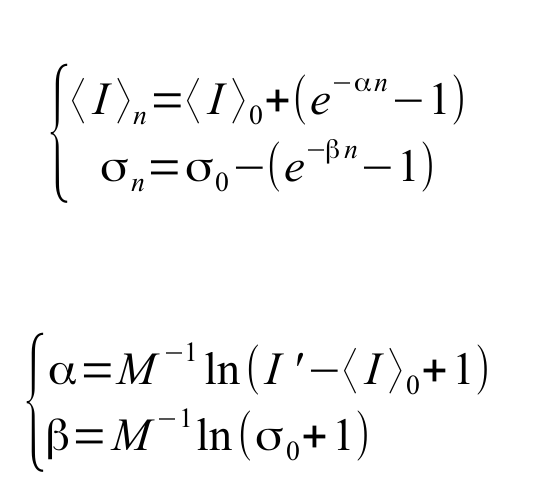

In [4]:
Image('../media/parametric_equations.png', width=300, height=300)

In [5]:
# expec_ns = sys_model.expec_ns()
# sigma2_ns = sys_model.sigma2_ns()

# apha = sys_model.get_alpha()
# beta = sys_model.get_beta()

l_pdfs, l_probs = sys_model_lognorm.get_prob_bins(dist="lognorm")
n_pdfs, n_probs = sys_model_norm.get_prob_bins(dist="norm")

print(l_pdfs)

[[6.94873166e-002 5.12034580e-009 1.30651371e-022 1.15438210e-042
  3.53188152e-069 3.74182609e-102 1.37272013e-141 1.74381871e-187
  7.67081656e-240 1.16843025e-298 0.00000000e+000]
 [6.25742031e-001 5.36308926e-006 3.09809930e-018 1.20624702e-037
  3.16546694e-064 5.59886406e-098 6.67456052e-139 5.36297827e-187
  2.90435709e-242 1.06011894e-304 0.00000000e+000]
 [3.59002729e-001 5.56834593e-003 7.52592094e-013 8.86335372e-031
  9.09581244e-057 8.13373272e-091 6.33786936e-133 4.30330031e-183
  2.54603876e-241 1.31260288e-307 0.00000000e+000]
 [2.21781936e-004 4.59119845e-001 5.96794599e-007 4.87105044e-022
  2.49642942e-046 8.03368650e-080 1.62333963e-122 2.05969458e-174
  1.64094938e-235 8.20892834e-306 0.00000000e+000]
 [2.50061283e-014 7.49173676e-003 4.22606106e-002 4.48855170e-012
  8.97622854e-033 3.37986050e-064 2.39618782e-106 3.19860153e-159
  8.03927030e-223 3.80443638e-297 0.00000000e+000]
 [2.79921584e-039 1.90745977e-014 1.80454961e-002 2.37015475e-003
  4.32194284e-017 1

## Generate data

In [6]:
# data, bins_center = sys_model.create_data()

## Get pdfs and probs of I for each n:

#### function returns a numpy array with size [n_max x n_bins].


-------------------


                bins
         -------------------  <- n=0 
         -------------------
         -------------------
         -------------------
      n  -------------------
         -------------------
         -------------------
         -------------------  <- nmax 
         
         
-------------------


In [7]:
# data fitted in norm and probs without poisson weight
l_pdfs, l_probs = sys_model_lognorm.get_prob_bins(dist="lognorm")
n_pdfs, n_probs = sys_model_norm.get_prob_bins(dist="norm")

# the sum of probs take into consideration the total prob of each n-normal
print(f"Sum log-norm prob array = {np.sum(l_probs)}, nor prob array={np.sum(n_probs)}")

# probs with Poisson weight
lw_probs = sys_model_lognorm.get_probs(dist="lognorm")
nw_probs = sys_model_norm.get_probs(dist="norm")

# reassessed probs with Poisson weight
rl_probs = sys_model_lognorm.reassessment_probs(lw_probs)
rn_probs = sys_model_norm.reassessment_probs(nw_probs)

# # the prob of normal weighted by Poisson is 1
# print(f"Sum Poisson * norm prob array = {np.sum(w_probs)}")

Sum log-norm prob array = 11.000000000000002, nor prob array=10.999999999996017


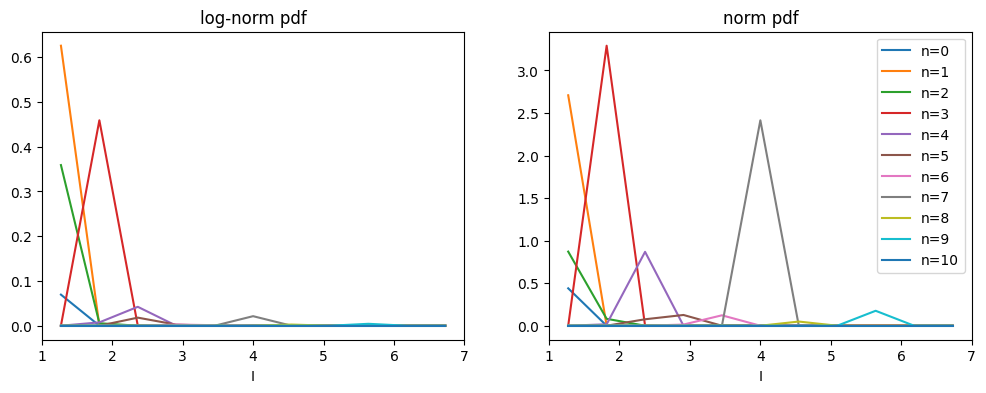

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
cmap = "plasma"

_, xs= sys_model_norm.create_data()
for n, curve in enumerate(l_pdfs):
    axs[0].plot(xs, curve, label=f"n={n}")
#lc = axs[0, 0].imshow(l_pdfs[::-1], extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[0].set_title("log-norm pdf")
axs[0].set_xlabel("I")


_, x = sys_model_norm.create_data()
for n, curve in enumerate(n_pdfs):
    axs[1].plot(x, curve, label=f"n={n}")
#nc = axs[1].imshow(n_pdfs[::-1], extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[1].set_title("norm pdf")
axs[1].set_xlabel("I")

plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


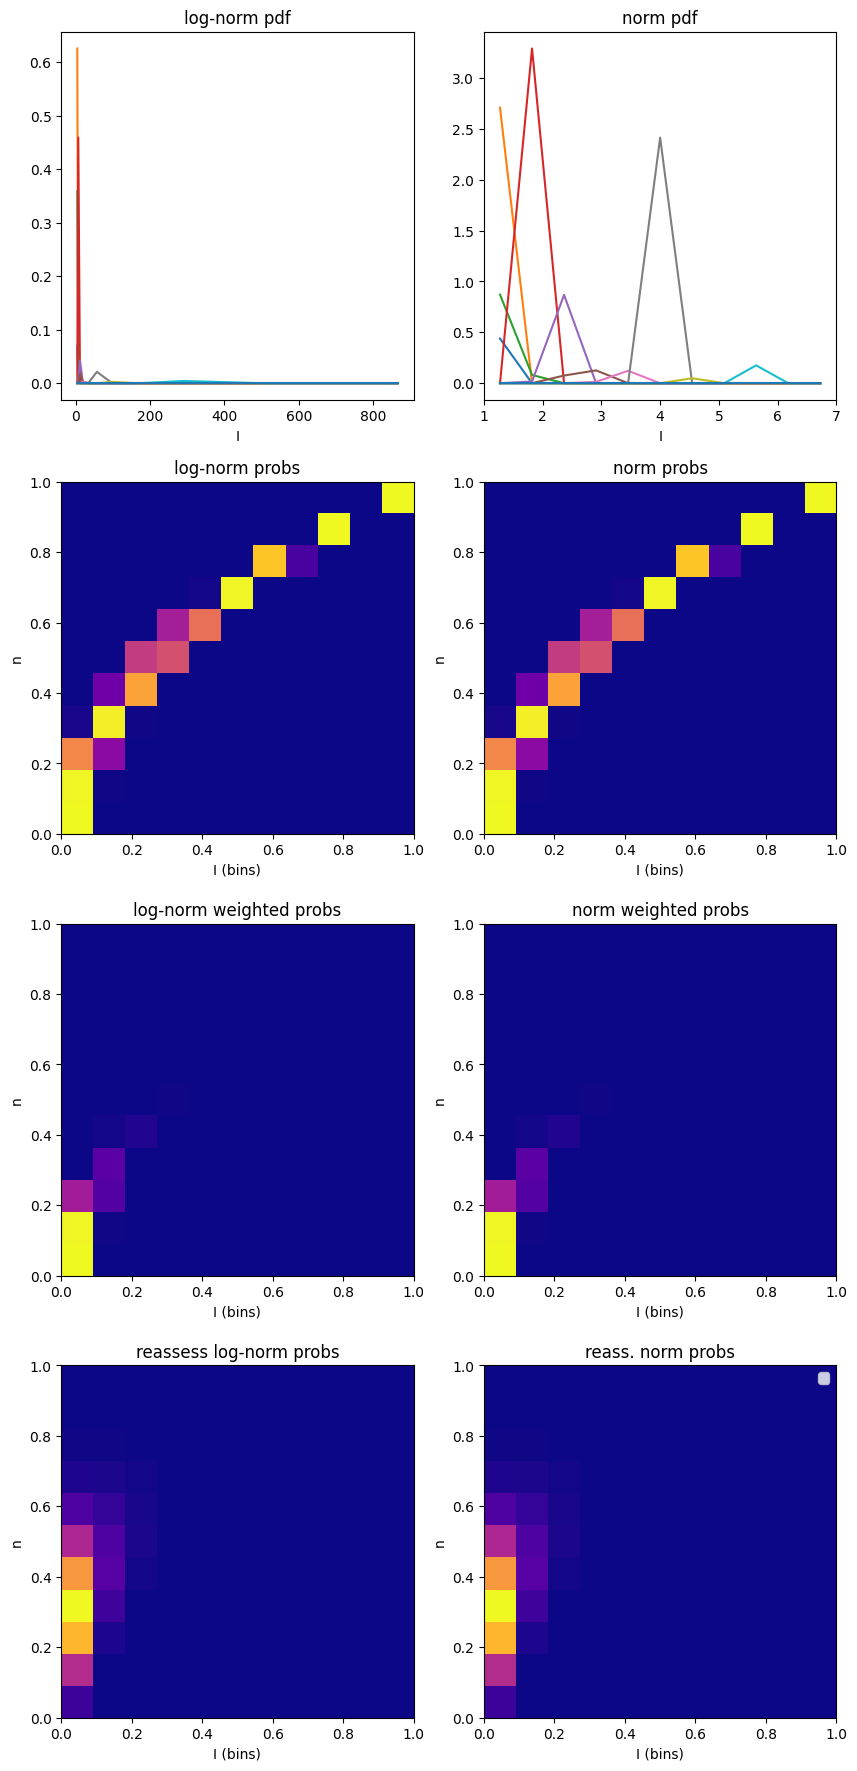

In [9]:
fig, axs = plt.subplots(4, 2, figsize=(10, 22))
cmap = "plasma"

_, xs= sys_model_norm.create_data_s()
for n, curve in enumerate(l_pdfs):
    axs[0, 0].plot(xs, curve, label=f"n={n}")
#lc = axs[0, 0].imshow(l_pdfs[::-1], extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[0, 0].set_title("log-norm pdf")
axs[0, 0].set_xlabel("I")


_, x = sys_model_norm.create_data()
for n, curve in enumerate(n_pdfs):
    axs[0, 1].plot(x, curve, label=f"n={n}")
#nc = axs[0, 1].imshow(n_pdfs[::-1], extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[0, 1].set_title("norm pdf")
axs[0, 1].set_xlabel("I")


lc = axs[1, 0].imshow(l_probs[::-1], extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[1, 0].set_title("log-norm probs")
axs[1, 0].set_xlabel("I (bins)")
axs[1, 0].set_ylabel("n")

nc = axs[1, 1].imshow(n_probs[::-1], extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[1, 1].set_title("norm probs")
axs[1, 1].set_xlabel("I (bins)")
axs[1, 1].set_ylabel("n")

lc = axs[2, 0].imshow(lw_probs[::-1], extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[2, 0].set_title("log-norm weighted probs")
axs[2, 0].set_xlabel("I (bins)")
axs[2, 0].set_ylabel("n")

nc = axs[2, 1].imshow(nw_probs[::-1], extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[2, 1].set_title("norm weighted probs")
axs[2, 1].set_xlabel("I (bins)")
axs[2, 1].set_ylabel("n")

lc = axs[3, 0].imshow(rl_probs[::-1], extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[3, 0].set_title("reassess log-norm probs")
axs[3, 0].set_xlabel("I (bins)")
axs[3, 0].set_ylabel("n")

nc = axs[3, 1].imshow(rn_probs[::-1], extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[3, 1].set_title("reass. norm probs")
axs[3, 1].set_xlabel("I (bins)")
axs[3, 1].set_ylabel("n")

plt.legend()
plt.show()

## Reassesses probs

In [10]:
# Reassessment doesn't change total probs

r_probs = sys_model.reassessment_probs(probs)
r_w_probs = sys_model.reassessment_probs(w_probs)

print(f"Sum reassessed norm prob array = {np.sum(r_probs)}")
print(f"Sum reassessed Poisson * norm prob array = {np.sum(r_w_probs)}")

NameError: name 'sys_model' is not defined

## For plotting:

#### For better representation, flip array: [n_max x n_bins][::-1].


-------------------


                bins
         -------------------  <- nmax  
         -------------------
         -------------------
         -------------------
      n  -------------------
         -------------------
         -------------------
         -------------------  <- n=0 
         
         
-------------------

In [ ]:
fig, axs = plt.subplots(1, 2)
cmap = "plasma"

z_prob = w_probs[::-1]
rz_prob = r_w_probs[::-1]

c = axs[0].imshow(z_prob, extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[0].set_title("probs")
axs[0].set_xlabel("I (bins)")
axs[0].set_ylabel("n")

rc = axs[1].imshow(rz_prob, extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[1].set_title("reassessed probs")
axs[1].set_xlabel("I (bins)")
axs[1].set_ylabel("n")

plt.show()

## GA Model Instance

In [ ]:
ga_model = GAModel()

## Get transitions matrix

In [ ]:
idx, transitions = ga_model.get_transitions_matrix(probs, n_step=n_step)


## Get best path in GA for a system

#### Method returns probs for each step and path.

In [ ]:
step_probs, path = ga_model.get_best_path(probs, minimize=False)

## Plot probs and best paths

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(17, 20))
cmap = "plasma"

i_0s = [2, 3, 4, 5] 
sigmas2_0 = [0.02, 0.1, 0.2, 0.5]

for idx1, i0 in enumerate(i_0s):
    for idx2, s0 in enumerate(sigmas2_0):

        sys_model = ProteinSystemModel(M, i0, i_nat, s0)
        prob_arr = sys_model.get_probs()
        ga_model = GAModel()
        path = ga_model.get_best_path(prob_arr, minimize=minimize)[0]
        z_prob = np.fliplr(prob_arr[::-1]) if minimize else prob_arr[::-1]
        c = axs[idx1, idx2].imshow(z_prob, extent=[0, 1, 0, 1], 
                                   cmap=cmap,  interpolation='nearest')
        x = [(x[1] / n_bins) + 0.5 * 1 / n_bins for x in path]
        y = [(x[0] / (n_max)) + 0.5 * 1 / (n_max) for x in path]
        ax=axs[idx1, idx2]
        fig.colorbar(c, ax=ax)
        axs[idx1, idx2].plot(x, y)
        axs[idx1, idx2].set_title("".join([r'$I _{0}$', f": {i0};  ", 
                                           r'$\sigma _{0} ^{2}$', f" :{s0}"]))
        
        if idx2 == 0:
            axs[idx1, idx2].set_ylabel("n")
        if idx1 == 3:
            axs[idx1, idx2].set_xlabel("I")
            

plt.show()